In [459]:
import pandas as pd
import os, sys
import ujson, re
import numpy as np
import seaborn as sns

from matplotlib import pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from gensim.models import Word2Vec
from src.DataReader import DataReader
from src.constants import SPLIT_TIME, STORE_LOCATION, DATA_ROOT, POSTS_FILE, VOTES_FILE
from operator import itemgetter

In [257]:
%matplotlib inline

In [23]:
emb_root = '/Users/prmathur/Documents/Pers/MMDS/Course/CS224W/Project/snap-master/examples/node2vec/emb/'

In [4]:
data_directory = DATA_ROOT

In [2]:
train_df = pd.read_csv(os.path.join(STORE_LOCATION, 'train.csv'))

In [443]:
test_df = pd.read_csv(os.path.join(STORE_LOCATION, 'test.csv'))

In [5]:
post_reader = DataReader(os.path.join(data_directory, POSTS_FILE), True)
post_reader.read_data()

Reading file...
Converting...
Progress | ██████████ | 100% || Estimated time remaining: 0.0 seconds
Conversion complete...
Forming data frame...


In [6]:
pdf = post_reader._df

In [14]:
q_tags_df = pdf[pdf.PostTypeId==1][['Id', 'Tags']]

In [17]:
train_df = train_df.merge(q_tags_df, how='left', left_on='QuestionId', right_on='Id', suffixes=('_tr', '_qt'))

In [444]:
test_df = test_df.merge(q_tags_df, how='left', left_on='QuestionId', right_on='Id', suffixes=('_tr', '_qt'))

In [21]:
train_df[['QuestionId', 'AcceptedAnswerUserId', 'UsersSorted', 'Tags']].head()

,QuestionId,AcceptedAnswerUserId,UsersSorted,Tags
0,5.0,45.0,"[45.0, 1102.0, 48.0, 226.0, 242.0]","[elementary-number-theory, proof-writing, radi..."
1,1.0,8.0,"[8.0, 49.0, 25.0, 35.0, 39.0]","[elementary-set-theory, intuition, faq]"
2,8.0,38.0,"[38.0, 173.0, 334.0, 53.0, 55.0]","[linear-algebra, combinatorics, generating-fun..."
3,2.0,34.0,"[34.0, 56.0, 35.0, 190287.0, 72.0]","[calculus, limits, definition]"
4,20.0,38.0,"[38.0, 72.0, 232.0, 51.0, 210.0]","[terminology, definition, number-systems]"


In [36]:
indx2tag_dict = {}
tag2index_dict = {}
with open(os.path.join(STORE_LOCATION, 'graphs/user-tag_keys.txt')) as tg_fl:
    for row in tg_fl:
        k, v = row.strip().split(',')
        indx2tag_dict[float(v.strip())] = k
        tag2index_dict[k] = float(v.strip())

In [124]:
# print model.syn0[model.vocab['10000958'].index].shape
# print model.index2word[169]

(128,)
10000958


In [84]:
def get_user_vals(users):
    return re.findall(r'[{]*(\d+).0', users)

In [226]:
def get_rep(row, model):
    tags = row.Tags
    tag_id = [str(int(tag2index_dict[t])) for t in tags]
    w2v_idx = [model.vocab[t].index for t in tag_id]
    t_vectors = model.syn0[w2v_idx]
    q = t_vectors.mean(axis=0)
    
    accepted_user = str(int(row.AcceptedAnswerUserId))
    user_vec = {}

    output = None
    
    users = get_user_vals(row.UsersSorted)
    for u in users:
        user = str(int(u))
        op_row = None
        
        if user in model.vocab:
            user_w2v_idx = model.vocab[user].index
            user_vector = model.syn0[user_w2v_idx]
        else:
            user_vector = np.zeros(128)
        
        if user == accepted_user:
            op_row = np.hstack((q, user_vector, 1))
        else:
            op_row = np.hstack((q, user_vector, 0))
            
        if output is None:
            output = op_row
        else:
            output = np.vstack((output, op_row))

    return output

In [343]:
def get_accuracy(preds, Y):
    pr, tr = [], []
    for i in range(0, preds.shape[0] ,5):
        pr.append(np.argmax(preds[i:i+5]))
        tr.append(np.argmax(Y[i:i+5]))

    pr = np.array(pr)
    tr = np.array(tr)
    
    return (pr==tr).sum()* 1. / pr.shape[0] 

In [345]:
# temp = get_rep(train_df.ix[0], model)

In [238]:
ut_files = [f for f in os.listdir(emb_root) if 'ut' in f]

In [407]:
uu_files = [f for f in os.listdir(emb_root) if 'uu' in f]

In [346]:
for emb_file in ut_files:
    model = Word2Vec.load_word2vec_format(os.path.join(emb_root, emb_file), binary=False)
    print 'Loaded {}\n'.format(emb_file)
    
    train_ds = []
    for indx, row in train_df.iterrows():
        temp_set = get_rep(row, model)
        train_ds.append(temp_set)
        
        if indx % 1000 == 0:
            sys.stdout.write('.')
            sys.stdout.flush()

    train_ds = np.vstack(train_ds)
    
    print '\nBegin train'
    clf = LogisticRegression(n_jobs=-1)
    clf.fit(train_ds[:, :256], train_ds[:, 256])
    preds = clf.predict_proba(train_ds[:, :256])[:, 1]
    score = get_accuracy(preds, train_ds[:, 256])

    p, q = emb_file.replace('.emb', '').replace('ut_', '').split('-')
    print '{0}; {1} : score - {2}'.format(p, q, score)

Loaded ut_p0.25-q0.25.emb

................
Begin train
p0.25; q0.25 : score - 0.39706254748
Loaded ut_p0.25-q0.50.emb

................
Begin train
p0.25; q0.50 : score - 0.406811851102
Loaded ut_p0.25-q1.emb

................
Begin train
p0.25; q1 : score - 0.403836414282
Loaded ut_p0.25-q2.emb

................
Begin train
p0.25; q2 : score - 0.39934160547
Loaded ut_p0.25-q4.emb

................
Begin train
p0.25; q4 : score - 0.405355786275
Loaded ut_p0.50-q0.25.emb

................
Begin train
p0.50; q0.25 : score - 0.399278298303
Loaded ut_p0.50-q0.50.emb

................
Begin train
p0.50; q0.50 : score - 0.399721448468
Loaded ut_p0.50-q1.emb

................
Begin train
p0.50; q1 : score - 0.403013421119
Loaded ut_p0.50-q2.emb

................
Begin train
p0.50; q2 : score - 0.406115472271
Loaded ut_p0.50-q4.emb

................
Begin train
p0.50; q4 : score - 0.403013421119
Loaded ut_p1-q0.25.emb

................
Begin train
p1; q0.25 : score - 0.398771840972
Loaded ut_

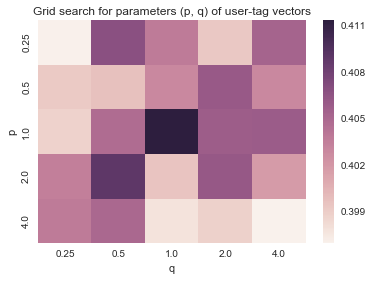

In [436]:
perf_df = pd.DataFrame([(0.25, 0.25, 0.39706254748), (0.25, 0.50, 0.406811851102), (0.25, 1, 0.403836414282), 
                        (0.25, 2, 0.39934160547), (0.25, 4, 0.405355786275), (0.50, 0.25, 0.399278298303), 
                        (0.50, 0.50, 0.399721448468), (0.50, 1, 0.403013421119), (0.50, 2, 0.406115472271), 
                        (0.50, 4, 0.403013421119), (1, 0.25, 0.398771840972), (1, 0.50, 0.404786021778), 
                        (1, 1, 0.411433274247), (1, 2, 0.405862243606), (1, 4, 0.405925550772), 
                        (2, 0.25, 0.40351987845), (2, 0.50, 0.409027601925), (2, 1, 0.399531526969), 
                        (2, 2, 0.406242086604), (2, 4, 0.401873892125), (4, 0.25, 0.403773107116), 
                        (4, 0.50, 0.40510255761), (4, 1, 0.397885540643), (4, 2, 0.398835148139), 
                        (4, 4, 0.396999240314)])

perf_df.columns = ['p', 'q', 'Accuracy']
ax = sns.heatmap(perf_df.pivot('p', 'q', 'Accuracy'))
plt.title('Grid search for parameters (p, q) of user-tag vectors')

In [383]:
def get_mrr(preds, Y):

    ranks = []
    for i in range(0, preds.shape[0] ,5):
        max_idx = np.argmax(Y[i:i+5])
        srt = np.argsort(preds[i:i+5],)[::-1]
        rank = np.where(srt==max_idx)[0][0] + 1

        ranks.append(rank)

    return np.mean(1. / np.array(ranks))

In [384]:
get_mrr(preds, Y)

0.63063750316535827

In [385]:
get_accuracy(preds, Y)

0.39699924031400352

In [387]:
ut_model = Word2Vec.load_word2vec_format(os.path.join(emb_root, 'ut_p1-q1.emb'), binary=False)

In [449]:
def get_rep_uu(row, ut_model, uu_model):
    tags = row.Tags
    tag_id = [str(int(tag2index_dict[t])) for t in tags if t in tag2index_dict]
    w2v_idx = [ut_model.vocab[t].index for t in tag_id if t in ut_model.vocab]
    t_vectors = ut_model.syn0[w2v_idx]
    q = t_vectors.mean(axis=0)
    
    accepted_user = str(int(row.AcceptedAnswerUserId))
    user_vec = {}

    output = None
    
    users = get_user_vals(row.UsersSorted)
    for u in users:
        user = str(int(u))
        op_row = None
        
        if user in ut_model.vocab:
            user_w2v_idx = ut_model.vocab[user].index
            user_vector = ut_model.syn0[user_w2v_idx]
        else:
#             print user
            user_vector = np.zeros(128)
            
        if user in uu_model.vocab:
            user_uu_w2v_idx = uu_model.vocab[user].index
            user_uu_vector = uu_model.syn0[user_uu_w2v_idx]
        else:
#             print user, users
            user_uu_vector = np.zeros(128)
        
        if user == accepted_user:
            op_row = np.hstack((q, user_vector, user_uu_vector, 1))
        else:
            op_row = np.hstack((q, user_vector, user_uu_vector, 0))
            
        if output is None:
            output = op_row
        else:
            output = np.vstack((output, op_row))

    return output

In [426]:
# get_rep_uu(train_df.ix[0], ut_model, uu_model).shape

In [418]:
# for indx, row in train_df.iterrows():
#     temp_set = get_rep_uu(train_df.ix[0], ut_model, uu_model)

In [433]:
for emb_file in uu_files:
#     model = Word2Vec.load_word2vec_format(os.path.join(emb_root, emb_file), binary=False)
    uu_model = Word2Vec.load_word2vec_format(os.path.join(emb_root, emb_file), binary=False)
    print 'Loaded {}\n'.format(emb_file)
    
    train_ds = []
    for indx, row in train_df.iterrows():
        temp_set = get_rep_uu(row, ut_model, uu_model)
        train_ds.append(temp_set)
        
        if indx % 1000 == 0:
            sys.stdout.write('.')
            sys.stdout.flush()

    train_ds = np.vstack(train_ds)
    
    print '\nBegin train'
    clf = LogisticRegression(n_jobs=-1)
    clf.fit(train_ds[:, :384], train_ds[:, 384])
    preds = clf.predict_proba(train_ds[:, :384])[:, 1]
    score = get_accuracy(preds, train_ds[:, 384])

    p, q = emb_file.replace('.emb', '').replace('ut_', '').split('-')
    print '{0}; {1} : score - {2}'.format(p, q, score)
    
#     break

Loaded uu_p0.25-q0.25.emb

................
Begin train
uu_p0.25; q0.25 : score - 0.423461635857
Loaded uu_p0.25-q0.50.emb

................
Begin train
uu_p0.25; q0.50 : score - 0.419030134211
Loaded uu_p0.25-q1.emb

................
Begin train
uu_p0.25; q1 : score - 0.420866042036
Loaded uu_p0.25-q2.emb

................
Begin train
uu_p0.25; q2 : score - 0.421309192201
Loaded uu_p0.25-q4.emb

................
Begin train
uu_p0.25; q4 : score - 0.424158014687
Loaded uu_p0.50-q0.25.emb

................
Begin train
uu_p0.50; q0.25 : score - 0.424474550519
Loaded uu_p0.50-q0.50.emb

................
Begin train
uu_p0.50; q0.50 : score - 0.419473284376
Loaded uu_p0.50-q1.emb

................
Begin train
uu_p0.50; q1 : score - 0.42010635604
Loaded uu_p0.50-q2.emb

................
Begin train
uu_p0.50; q2 : score - 0.418586984047
Loaded uu_p0.50-q4.emb

................
Begin train
uu_p0.50; q4 : score - 0.422005571031
Loaded uu_p1-q0.25.emb

................
Begin train
uu_p1; q0.25 :

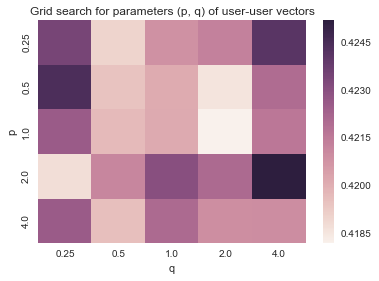

In [437]:
perf_df = pd.DataFrame([(0.25, 0.25, 0.423461635857), (0.25, 0.50, 0.419030134211), (0.25, 1, 0.420866042036), 
                        (0.25, 2, 0.421309192201), (0.25, 4, 0.424158014687), (0.50, 0.25, 0.424474550519), 
                        (0.50, 0.50, 0.419473284376), (0.50, 1, 0.42010635604), (0.50, 2, 0.418586984047), 
                        (0.50, 4, 0.422005571031), (1, 0.25, 0.422575335528), (1, 0.50, 0.419726513041), 
                        (1, 1, 0.420169663206), (1, 2, 0.418207141048), (1, 4, 0.421625728032), 
                        (2, 0.25, 0.418776905546), (2, 0.50, 0.421182577868), (2, 1, 0.423081792859), 
                        (2, 2, 0.422068878197), (2, 4, 0.425234236516), (4, 0.25, 0.422575335528), 
                        (4, 0.50, 0.419599898709), (4, 1, 0.422068878197), (4, 2, 0.420929349202), 
                        (4, 4, 0.420992656369)])

perf_df.columns = ['p', 'q', 'Accuracy']
ax = sns.heatmap(perf_df.pivot('p', 'q', 'Accuracy'))
plt.title('Grid search for parameters (p, q) of user-user vectors')

## Final perf

In [438]:
ut_model = Word2Vec.load_word2vec_format(os.path.join(emb_root, 'ut_p1-q1.emb'), binary=False)

In [439]:
uu_model = Word2Vec.load_word2vec_format(os.path.join(emb_root, 'uu_p2-q4.emb'), binary=False)

In [441]:
train_ds = []
for indx, row in train_df.iterrows():
    temp_set = get_rep_uu(row, ut_model, uu_model)
    train_ds.append(temp_set)

    if indx % 1000 == 0:
        sys.stdout.write('.')
        sys.stdout.flush()

train_ds = np.vstack(train_ds)

................

In [442]:
clf = LogisticRegression(n_jobs=-1)
clf.fit(train_ds[:, :384], train_ds[:, 384])
preds = clf.predict_proba(train_ds[:, :384])[:, 1]
print get_accuracy(preds, train_ds[:, 384])
print get_mrr(preds, train_ds[:, 384])

0.425234236516
0.650518063645


In [455]:
test_ds = []
for indx, row in test_df.iterrows():
    temp_set = get_rep_uu(row, ut_model, uu_model)
    test_ds.append(temp_set)

    if indx % 1000 == 0:
        sys.stdout.write('.')
        sys.stdout.flush()

test_ds = np.vstack(test_ds)

.....

In [456]:
test_ds.shape

(20730, 385)

In [458]:
preds = clf.predict_proba(test_ds[:, :384])[:, 1]
print get_accuracy(preds, test_ds[:, 384])
print get_mrr(preds, test_ds[:, 384])

0.480221900627
0.691739025567
